In [229]:
# Loading packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [230]:
# Loading data 
recipes = pd.read_parquet("../data/recipes.parquet")
reviews = pd.read_parquet("../data/reviews.parquet")

In [231]:
recipes.columns

Index(['RecipeId', 'Name', 'AuthorId', 'AuthorName', 'CookTime', 'PrepTime',
       'TotalTime', 'DatePublished', 'Description', 'Images', 'RecipeCategory',
       'Keywords', 'RecipeIngredientQuantities', 'RecipeIngredientParts',
       'AggregatedRating', 'ReviewCount', 'Calories', 'FatContent',
       'SaturatedFatContent', 'CholesterolContent', 'SodiumContent',
       'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent',
       'RecipeServings', 'RecipeYield', 'RecipeInstructions'],
      dtype='object')

In [232]:
info_attr = ['RecipeId', 'Name', 'RecipeIngredientParts', 'Description']

# Retrieving continuous attributes
continuous_attr = ['AggregatedRating', 'ReviewCount', 'Calories',  'FatContent','SaturatedFatContent', 
                    'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 
                    'SugarContent', 'ProteinContent', 'RecipeServings']

recipes_continuous = recipes[info_attr + continuous_attr]

# Calculating percentage of null values in each column
null_percentage = recipes_continuous[continuous_attr].isnull().mean().round(3).sort_values(ascending=False)
print(null_percentage, "\n")

AggregatedRating       0.485
ReviewCount            0.474
RecipeServings         0.350
Calories               0.000
FatContent             0.000
SaturatedFatContent    0.000
CholesterolContent     0.000
SodiumContent          0.000
CarbohydrateContent    0.000
FiberContent           0.000
SugarContent           0.000
ProteinContent         0.000
dtype: float64 



From the null values observations we have that `AggregatedRating`, `ReviewCount` and `RecipeServings` have a "high" percentage of null values. __For now__ instead of removing the rows that have `None` values in any of those columns, I will simply not include the columns in the cleaned version of continuous attributes.

In [233]:
# Updating continuous attributes

continuous_attr = ['Calories', 'FatContent','SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 
                   'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent']

recipes_continuous = recipes[info_attr + continuous_attr]

# Get the minimum positive value across all columns
min_positive_values = []
for column in continuous_attr:
    min_value = recipes_continuous[column][recipes_continuous[column] > 0].min()
    min_positive_values.append(min_value)

overall_min_positive_value = np.min(min_positive_values)
overall_min_positive_value

0.1

The overall minimum positive value across all continuous columns is $0.1$. Then, if we need to perform a log transformation we should replace the 0 column values for something very negligible, like $10^{-4}$.

In [234]:
# We get rid off the recipes with 0 in all of the continuous attributes

nonzero_mask = recipes_continuous[continuous_attr].min(axis=1) > 0
recipes_continuous = recipes_continuous[nonzero_mask]

# Alternative code to do the same as above:
# masks = []

# for column in continuous_attr:
#     mask = recipes_continuous[column] > 0
#     masks.append(mask)

# combined_mask = pd.concat(masks, axis=1).any(axis=1)
# recipes_continuous = recipes_continuous[combined_mask]

### General idea
For each one of the continuous attributes I will get the indices of the data that has close to "normal" attribute values (for example, using the IQR method). Then, I will get rif of outlier in general by slicing the `recipes_continous` dataframe with the intersection of the indices. 

#### Cleaning `Calories`

In the plots below I am applying a logarithmic transformation because the `Calories` seemed to be highly skewed to the left. To see this run the plots below by setting `data=recipes_continuous['Calories']` and `log_scale=False`.

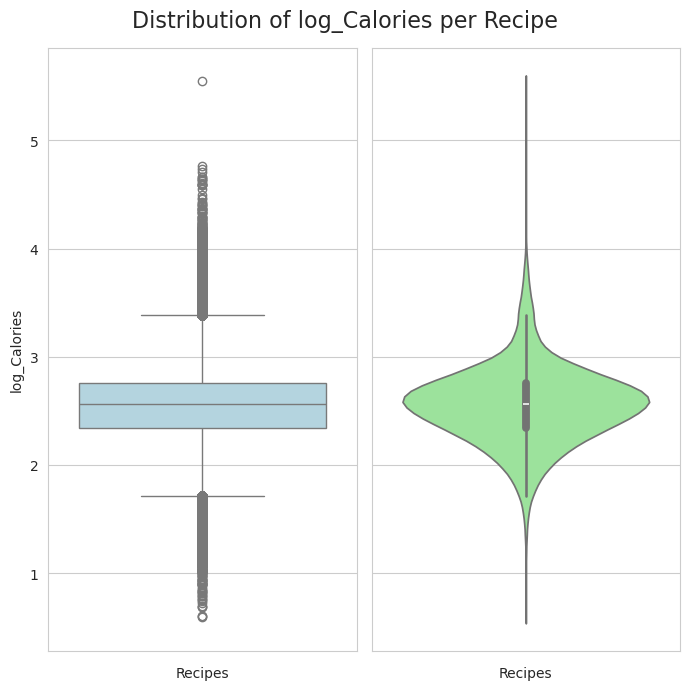

In [235]:
recipes_continuous = recipes_continuous.copy()
recipes_continuous['log_Calories'] = recipes_continuous['Calories'].apply(lambda x: np.log10(x) if x > 0 else -4)

sns.set_style('whitegrid')
fig, axes = plt.subplots(ncols=2, figsize=(7, 7), sharey=True)

# Plotting box and violin plots with log scale
sns.boxplot(data=recipes_continuous['log_Calories'], ax=axes[0], color="lightblue")
axes[0].set_xlabel('Recipes')
axes[0].set_ylabel('log_Calories')

sns.violinplot(data=recipes_continuous['log_Calories'], color="lightgreen", ax=axes[1])
axes[1].set_xlabel('Recipes')
axes[1].set_ylabel('log_Calories')

plt.suptitle('Distribution of log_Calories per Recipe', fontsize=16)  
plt.tight_layout()
plt.show()

In [236]:
Q1 = recipes_continuous['log_Calories'].quantile(0.25)
Q3 = recipes_continuous['log_Calories'].quantile(0.75)

# Calculate IQR (Interquartile Range)
IQR = Q3 - Q1
lower_bound = Q1 - 2.5 * IQR
upper_bound = Q3 + 2 * IQR

print("Calories lower bound:", round(10 ** lower_bound, 3))
print("Calories upper bound:", round(10 ** upper_bound, 3))

# Filter the data for possible outliers
clean_Calories_indices = (recipes_continuous['log_Calories'] >= lower_bound) & (recipes_continuous['log_Calories'] <= upper_bound)
outliers_Calories_indices = (recipes_continuous['log_Calories'] < lower_bound) | (recipes_continuous['log_Calories'] > upper_bound)

Calories lower bound: 19.723
Calories upper bound: 3939.589


#### Cleaning `FatContent`

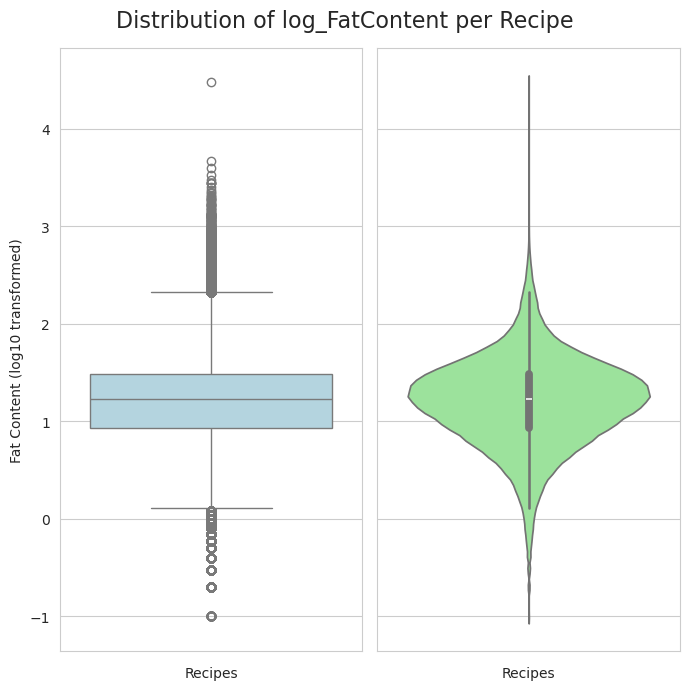

In [237]:
# We run the line below in order to avoid problems when applying log transformation
recipes_continuous = recipes_continuous.copy()
recipes_continuous['log_FatContent'] = recipes_continuous['FatContent'].apply(lambda x: np.log10(x) if x > 0 else -4)

sns.set_style('whitegrid')
fig, axes = plt.subplots(ncols=2, figsize=(7, 7), sharey=True)

# Plotting box and violin plots with log scale
sns.boxplot(data=recipes_continuous['log_FatContent'], ax=axes[0], color="lightblue")
axes[0].set_xlabel('Recipes')
axes[0].set_ylabel('Fat Content (log10 transformed)')

sns.violinplot(data=recipes_continuous['log_FatContent'], color="lightgreen", ax=axes[1])
axes[1].set_xlabel('Recipes')
axes[1].set_ylabel('Fat Content (log10 transformed)')

plt.suptitle('Distribution of log_FatContent per Recipe', fontsize=16)  
plt.tight_layout()
plt.show()

In [238]:
Q1 = recipes_continuous['log_FatContent'].quantile(0.25)
Q3 = recipes_continuous['log_FatContent'].quantile(0.75)

# Calculate IQR (Interquartile Range)
IQR = Q3 - Q1
lower_bound = Q1 - 1.6 * IQR
upper_bound = Q3 + 1.6 * IQR

print("Fat Content lower bound:", round(10 ** lower_bound, 3))
print("Fat Content upper bound:", round(10 ** upper_bound, 3))

# Filter the data for possible outliers
clean_FatContent_indices = (recipes_continuous['log_FatContent'] >= lower_bound) & (recipes_continuous['log_FatContent'] <= upper_bound)
outliers_FatContent_indices = (recipes_continuous['log_FatContent'] < lower_bound) | (recipes_continuous['log_FatContent'] > upper_bound)

Fat Content lower bound: 1.105
Fat Content upper bound: 241.181


#### Cleaning `SaturatedFatContent`

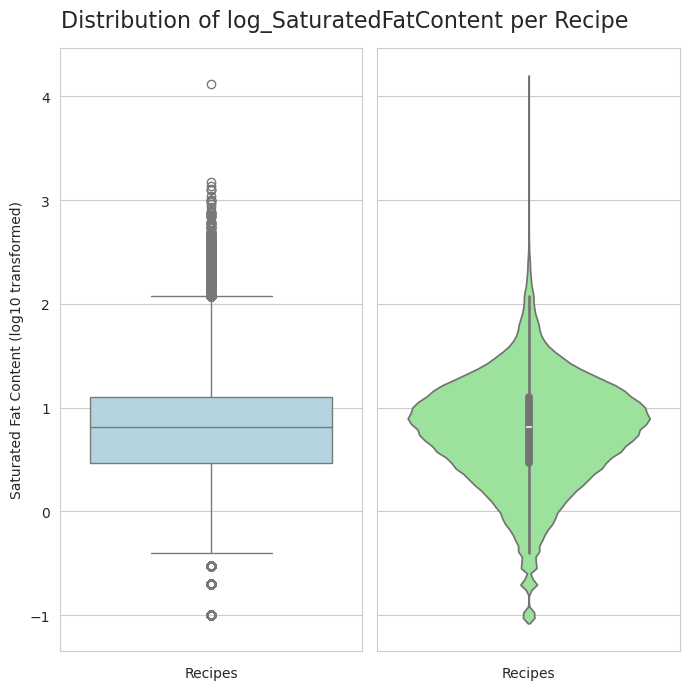

In [239]:
# We run the line below in order to avoid problems when applying log transformation
recipes_continuous = recipes_continuous.copy()
recipes_continuous['log_SaturatedFatContent'] = recipes_continuous['SaturatedFatContent'].apply(lambda x: np.log10(x) if x > 0 else -4)

sns.set_style('whitegrid')
fig, axes = plt.subplots(ncols=2, figsize=(7, 7), sharey=True)

# Plotting box and violin plots with log scale
sns.boxplot(data=recipes_continuous['log_SaturatedFatContent'], ax=axes[0], color="lightblue")
axes[0].set_xlabel('Recipes')
axes[0].set_ylabel('Saturated Fat Content (log10 transformed)')

sns.violinplot(data=recipes_continuous['log_SaturatedFatContent'], color="lightgreen", ax=axes[1])
axes[1].set_xlabel('Recipes')
axes[1].set_ylabel('Saturated Fat Content (log10 transformed)')

plt.suptitle('Distribution of log_SaturatedFatContent per Recipe', fontsize=16)  
plt.tight_layout()
plt.show()

In [240]:
Q1 = recipes_continuous['log_SaturatedFatContent'].quantile(0.25)
Q3 = recipes_continuous['log_SaturatedFatContent'].quantile(0.75)

# Calculate IQR (Interquartile Range)
IQR = Q3 - Q1
lower_bound = Q1 - 4 * IQR
upper_bound = Q3 + 1.75 * IQR

print("Saturated Fat Content lower bound:", round(10 ** lower_bound, 3))
print("Saturated Fat Content upper bound:", round(10 ** upper_bound, 3))

# Filter the data for possible outliers
clean_SaturatedFatContent_indices = (recipes_continuous['log_SaturatedFatContent'] >= lower_bound) & (recipes_continuous['log_SaturatedFatContent'] <= upper_bound)
outliers_SaturatedFatContent_indices = (recipes_continuous['log_SaturatedFatContent'] < lower_bound) | (recipes_continuous['log_SaturatedFatContent'] > upper_bound)

# recipes_continuous[outliers_SaturatedFatContent_indices].sample(5)

Saturated Fat Content lower bound: 0.008
Saturated Fat Content upper bound: 172.041


#### Cleaning `SodiumContent`

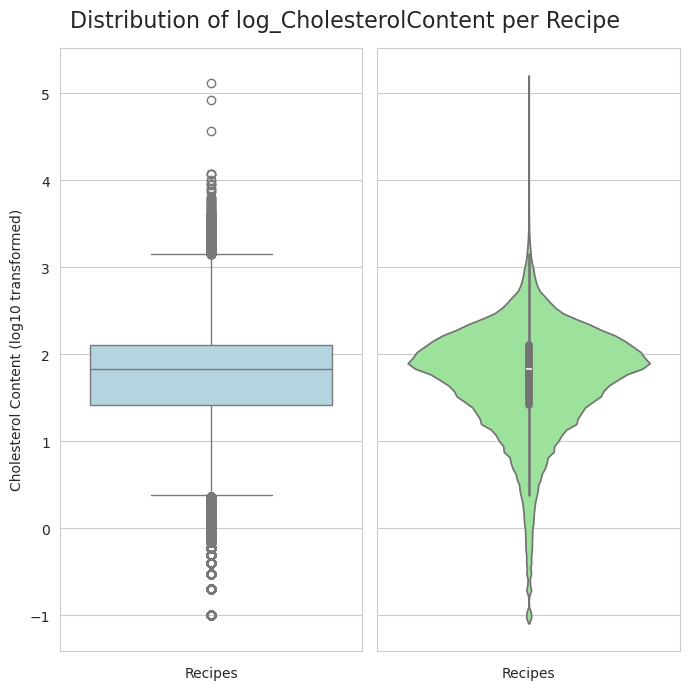

In [241]:
# We run the line below in order to avoid problems when applying log transformation
recipes_continuous = recipes_continuous.copy()
recipes_continuous['log_CholesterolContent'] = recipes_continuous['CholesterolContent'].apply(lambda x: np.log10(x) if x > 0 else -4)

sns.set_style('whitegrid')
fig, axes = plt.subplots(ncols=2, figsize=(7, 7), sharey=True)

# Plotting box and violin plots with log scale
sns.boxplot(data=recipes_continuous['log_CholesterolContent'], ax=axes[0], color="lightblue")
axes[0].set_xlabel('Recipes')
axes[0].set_ylabel('Cholesterol Content (log10 transformed)')

sns.violinplot(data=recipes_continuous['log_CholesterolContent'], color="lightgreen", ax=axes[1])
axes[1].set_xlabel('Recipes')
axes[1].set_ylabel('Cholesterol Content (log10 transformed)')

plt.suptitle('Distribution of log_CholesterolContent per Recipe', fontsize=16)  
plt.tight_layout()
plt.show()

In [242]:
Q1 = recipes_continuous['log_CholesterolContent'].quantile(0.25)
Q3 = recipes_continuous['log_CholesterolContent'].quantile(0.75)

# Calculate IQR (Interquartile Range)
IQR = Q3 - Q1
lower_bound = Q1 - 4 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Cholesterol Content lower bound:", round(10 ** lower_bound, 3))
print("Cholesterol Content upper bound:", round(10 ** upper_bound, 3))

# Filter the data for possible outliers
clean_CholesterolContent_indices = (recipes_continuous['log_CholesterolContent'] >= lower_bound) & (recipes_continuous['log_CholesterolContent'] <= upper_bound)
outliers_CholesterolContent_indices = (recipes_continuous['log_CholesterolContent'] < lower_bound) | (recipes_continuous['log_CholesterolContent'] > upper_bound)

# recipes_continuous[outliers_CholesterolContent_indices]

Cholesterol Content lower bound: 0.043
Cholesterol Content upper bound: 1434.072


#### Cleaning `SodiumContent`

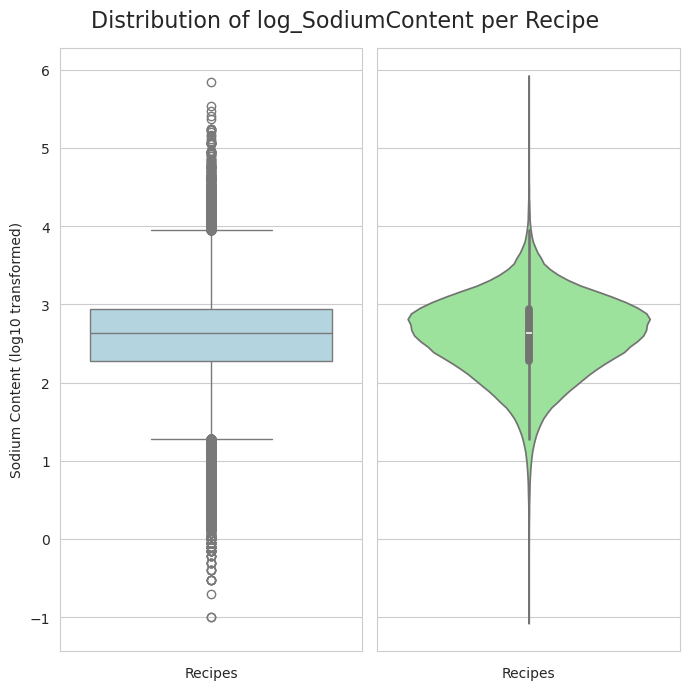

In [243]:
# We run the line below in order to avoid problems when applying log transformation
recipes_continuous = recipes_continuous.copy()
recipes_continuous['log_SodiumContent'] = recipes_continuous['SodiumContent'].apply(lambda x: np.log10(x) if x > 0 else -4)

sns.set_style('whitegrid')
fig, axes = plt.subplots(ncols=2, figsize=(7, 7), sharey=True)

# Plotting box and violin plots with log scale
sns.boxplot(data=recipes_continuous['log_SodiumContent'], ax=axes[0], color="lightblue")
axes[0].set_xlabel('Recipes')
axes[0].set_ylabel('Sodium Content (log10 transformed)')

sns.violinplot(data=recipes_continuous['log_SodiumContent'], color="lightgreen", ax=axes[1])
axes[1].set_xlabel('Recipes')
axes[1].set_ylabel('Sodium Content (log10 transformed)')

plt.suptitle('Distribution of log_SodiumContent per Recipe', fontsize=16)  
plt.tight_layout()
plt.show()

In [244]:
Q1 = recipes_continuous['log_SodiumContent'].quantile(0.25)
Q3 = recipes_continuous['log_SodiumContent'].quantile(0.75)

# Calculate IQR (Interquartile Range)
IQR = Q3 - Q1
lower_bound = Q1 - 2 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Sodium Content lower bound:", round(10 ** lower_bound, 3))
print("Sodium Content upper bound:", round(10 ** upper_bound, 3))

# Filter the data for possible outliers
clean_SodiumContent_indices = (recipes_continuous['log_SodiumContent'] >= lower_bound) & (recipes_continuous['log_SodiumContent'] <= upper_bound)
outliers_SodiumContent_indices = (recipes_continuous['log_SodiumContent'] < lower_bound) | (recipes_continuous['log_SodiumContent'] > upper_bound)

# recipes_continuous[outliers_SodiumContent_indices]

Sodium Content lower bound: 8.75
Sodium Content upper bound: 8842.711


#### Cleaning `CarbohydrateContent`

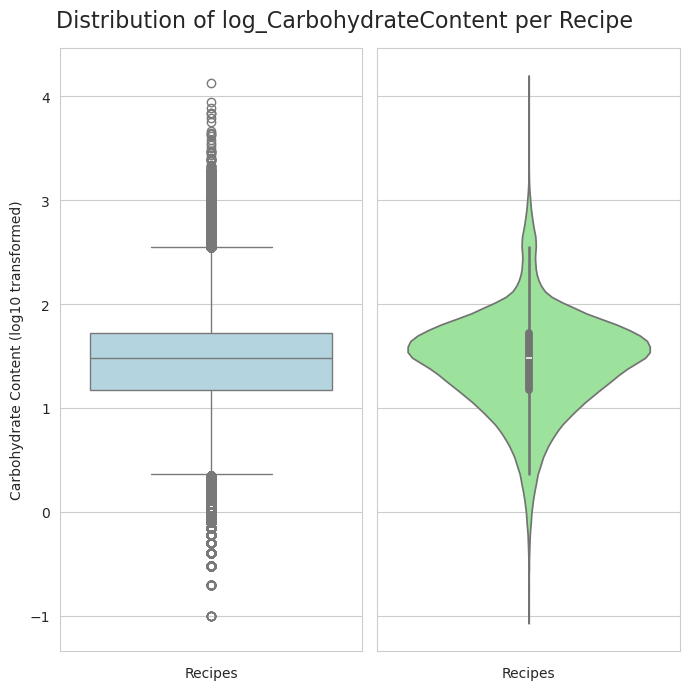

In [309]:
# We run the line below in order to avoid problems when applying log transformation
recipes_continuous = recipes_continuous.copy()
recipes_continuous['log_CarbohydrateContent'] = recipes_continuous['CarbohydrateContent'].apply(lambda x: np.log10(x) if x > 0 else -4)

sns.set_style('whitegrid')
fig, axes = plt.subplots(ncols=2, figsize=(7, 7), sharey=True)

# Plotting box and violin plots with log scale
sns.boxplot(data=recipes_continuous['log_CarbohydrateContent'], ax=axes[0], color="lightblue")
axes[0].set_xlabel('Recipes')
axes[0].set_ylabel('Carbohydrate Content (log10 transformed)')

sns.violinplot(data=recipes_continuous['log_CarbohydrateContent'], color="lightgreen", ax=axes[1])
axes[1].set_xlabel('Recipes')
axes[1].set_ylabel('Carbohydrate Content (log10 transformed)')

plt.suptitle('Distribution of log_CarbohydrateContent per Recipe', fontsize=16)  
plt.tight_layout()
plt.show()


Carbohydrate Content lower bound: 1.167
Carbohydrate Content upper bound: 917.901


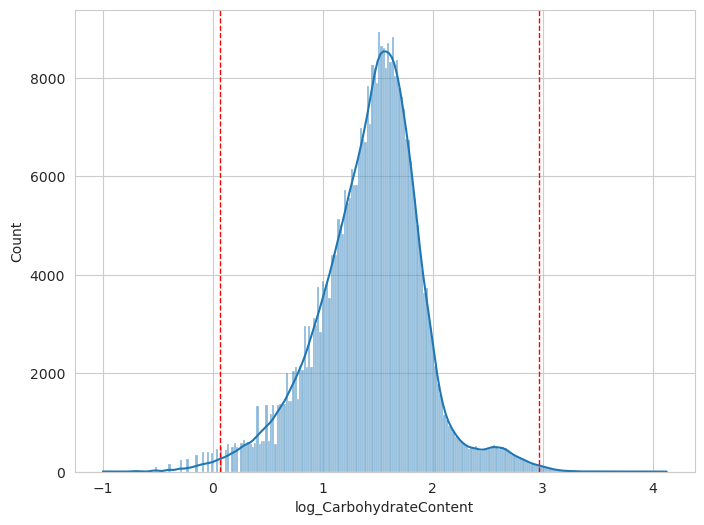

In [319]:
Q1 = recipes_continuous['log_CarbohydrateContent'].quantile(0.25)
Q3 = recipes_continuous['log_CarbohydrateContent'].quantile(0.75)

# Calculate IQR (Interquartile Range)
IQR = Q3 - Q1
lower_bound = Q1 - 2 * IQR
upper_bound = Q3 + 2.25 * IQR

print("Carbohydrate Content lower bound:", round(10 ** lower_bound, 3))
print("Carbohydrate Content upper bound:", round(10 ** upper_bound, 3))

# Plot histogram and whisker boundaries as vertical lines
plt.figure(figsize=(8,6))
sns.histplot(data=recipes_continuous, x='log_CarbohydrateContent', bins=250, kde=True)

plt.axvline(x=lower_bound, color='r', linestyle='--', linewidth=1)
plt.axvline(x=upper_bound, color='r', linestyle='--', linewidth=1)

plt.show()

# Filter the data for possible outliers
clean_CarbohydrateContent_indices = (recipes_continuous['log_CarbohydrateContent'] >= lower_bound) & (recipes_continuous['log_CarbohydrateContent'] <= upper_bound)
outliers_CarbohydrateContent_indices = (recipes_continuous['log_CarbohydrateContent'] < lower_bound) | (recipes_continuous['log_CarbohydrateContent'] > upper_bound)

# recipes_continuous[outliers_CarbohydrateContent_indices]

#### Cleaning `FiberContent`

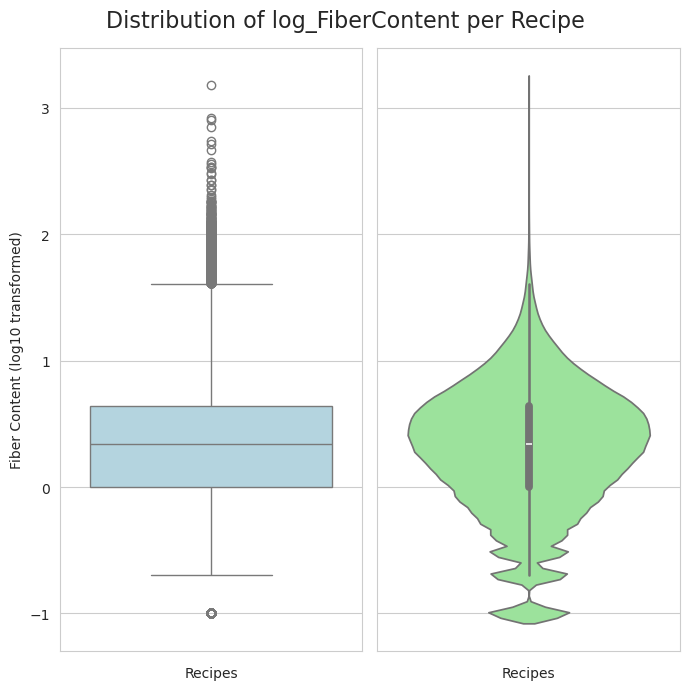

In [315]:
# We run the line below in order to avoid problems when applying log transformation
recipes_continuous = recipes_continuous.copy()
recipes_continuous['log_FiberContent'] = recipes_continuous['FiberContent'].apply(lambda x: np.log10(x) if x > 0 else -4)

sns.set_style('whitegrid')
fig, axes = plt.subplots(ncols=2, figsize=(7, 7), sharey=True)

# Plotting box and violin plots with log scale
sns.boxplot(data=recipes_continuous['log_FiberContent'], ax=axes[0], color="lightblue")
axes[0].set_xlabel('Recipes')
axes[0].set_ylabel('Fiber Content (log10 transformed)')

sns.violinplot(data=recipes_continuous['log_FiberContent'], color="lightgreen", ax=axes[1])
axes[1].set_xlabel('Recipes')
axes[1].set_ylabel('Fiber Content (log10 transformed)')

plt.suptitle('Distribution of log_FiberContent per Recipe', fontsize=16)  
plt.tight_layout()
plt.show()

Fiber Content lower bound: 0.093
Fiber Content upper bound: 98.788


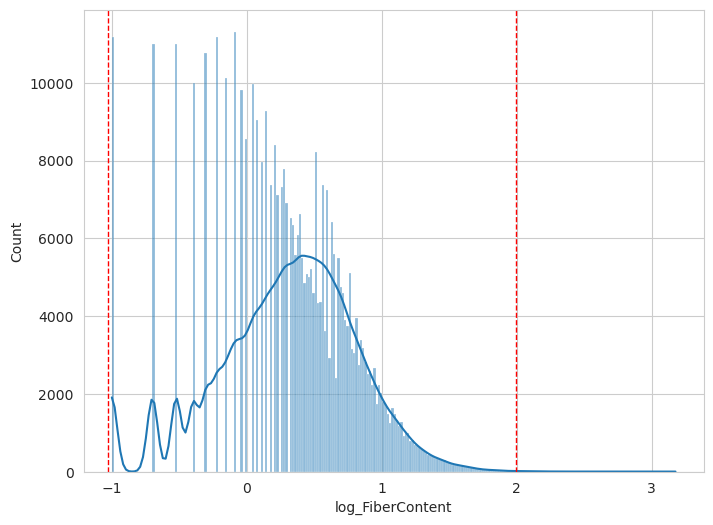

In [325]:
Q1 = recipes_continuous['log_FiberContent'].quantile(0.25)
Q3 = recipes_continuous['log_FiberContent'].quantile(0.75)

# Calculate IQR (Interquartile Range)
IQR = Q3 - Q1
lower_bound = Q1 - 1.6 * IQR
upper_bound = Q3 + 2.1 * IQR

print("Fiber Content lower bound:", round(10 ** lower_bound, 3))
print("Fiber Content upper bound:", round(10 ** upper_bound, 3))

# Plot histogram and whisker boundaries as vertical lines
plt.figure(figsize=(8,6))
sns.histplot(data=recipes_continuous, x='log_FiberContent', bins=250, kde=True)

plt.axvline(x=lower_bound, color='r', linestyle='--', linewidth=1)
plt.axvline(x=upper_bound, color='r', linestyle='--', linewidth=1)

plt.show()

# Filter the data for possible outliers
clean_FiberContent_indices = (recipes_continuous['log_FiberContent'] >= lower_bound) & (recipes_continuous['log_FiberContent'] <= upper_bound)
outliers_FiberContent_indices = (recipes_continuous['log_FiberContent'] < lower_bound) | (recipes_continuous['log_FiberContent'] > upper_bound)

# recipes_continuous[outliers_FiberContent_indices]

#### Cleaning `SugarContent`

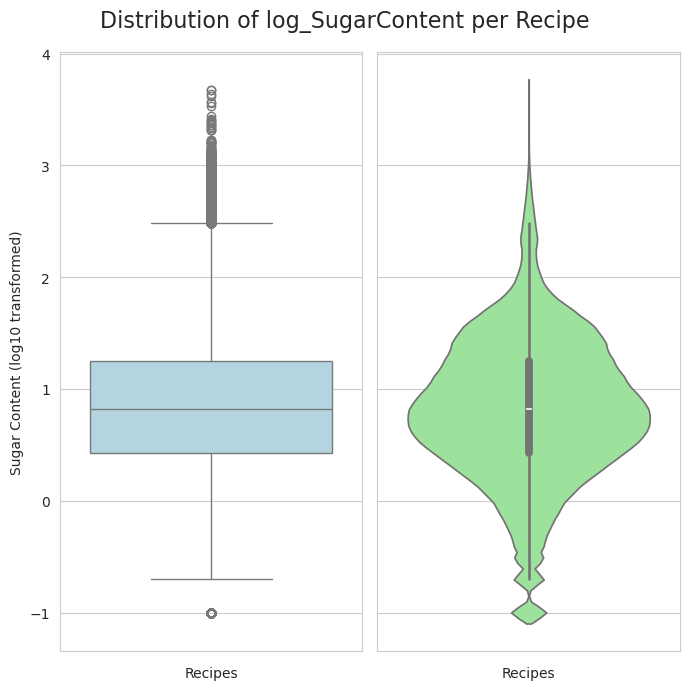

In [326]:
# We run the line below in order to avoid problems when applying log transformation
recipes_continuous = recipes_continuous.copy()
recipes_continuous['log_SugarContent'] = recipes_continuous['SugarContent'].apply(lambda x: np.log10(x) if x > 0 else -4)

sns.set_style('whitegrid')
fig, axes = plt.subplots(ncols=2, figsize=(7, 7), sharey=True)

# Plotting box and violin plots with log scale
sns.boxplot(data=recipes_continuous['log_SugarContent'], ax=axes[0], color="lightblue")
axes[0].set_xlabel('Recipes')
axes[0].set_ylabel('Sugar Content (log10 transformed)')

sns.violinplot(data=recipes_continuous['log_SugarContent'], color="lightgreen", ax=axes[1])
axes[1].set_xlabel('Recipes')
axes[1].set_ylabel('Sugar Content (log10 transformed)')

plt.suptitle('Distribution of log_SugarContent per Recipe', fontsize=16)  
plt.tight_layout()
plt.show()



Sugar Content lower bound: 0.061
Sugar Content upper bound: 786.741


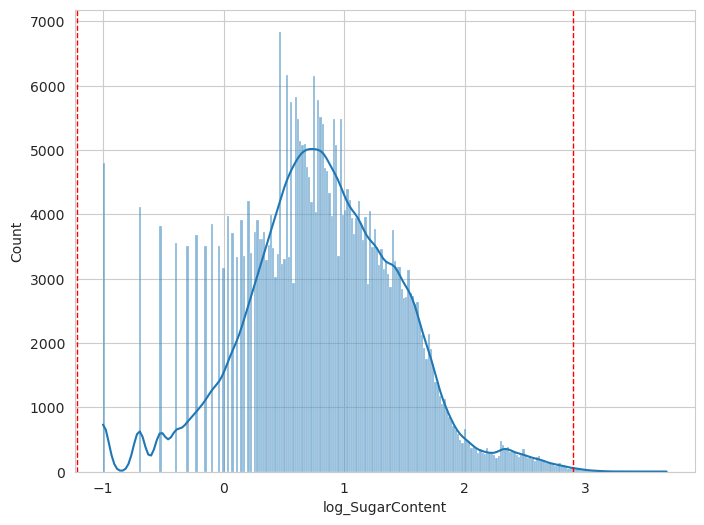

In [327]:
Q1 = recipes_continuous['log_SugarContent'].quantile(0.25)
Q3 = recipes_continuous['log_SugarContent'].quantile(0.75)

# Calculate IQR (Interquartile Range)
IQR = Q3 - Q1
lower_bound = Q1 - 2 * IQR
upper_bound = Q3 + 2 * IQR

print("Sugar Content lower bound:", round(10 ** lower_bound, 3))
print("Sugar Content upper bound:", round(10 ** upper_bound, 3))

# Plot histogram and whisker boundaries as vertical lines
plt.figure(figsize=(8,6))
sns.histplot(data=recipes_continuous, x='log_SugarContent', bins=250, kde=True)

plt.axvline(x=lower_bound, color='r', linestyle='--', linewidth=1)
plt.axvline(x=upper_bound, color='r', linestyle='--', linewidth=1)

plt.show()

# Filter the data for possible outliers
clean_SugarContent_indices = (recipes_continuous['log_SugarContent'] >= lower_bound) & (recipes_continuous['log_SugarContent'] <= upper_bound)
outliers_SugarContent_indices = (recipes_continuous['log_SugarContent'] < lower_bound) | (recipes_continuous['log_SugarContent'] > upper_bound)

# recipes_continuous[outliers_SugarContent_indices]

#### Cleaning `ProteinContent`

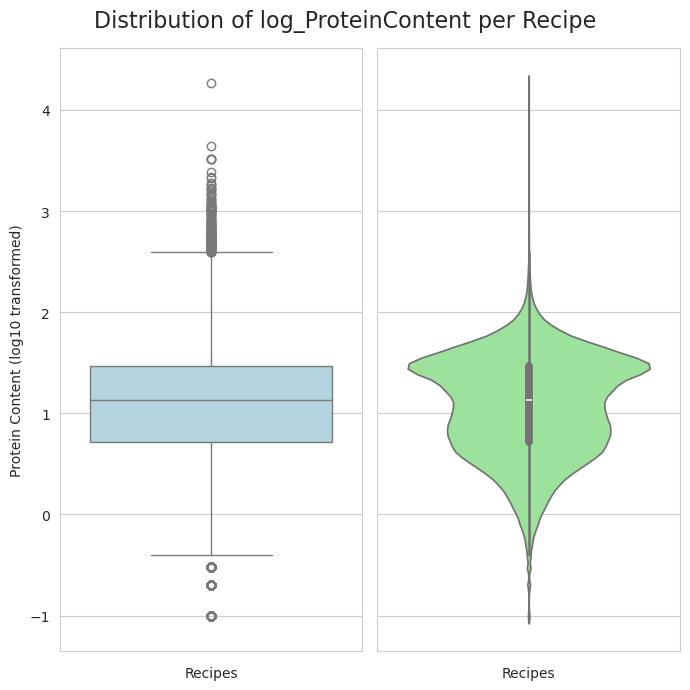

In [328]:
# We run the line below in order to avoid problems when applying log transformation
recipes_continuous = recipes_continuous.copy()
recipes_continuous['log_ProteinContent'] = recipes_continuous['ProteinContent'].apply(lambda x: np.log10(x) if x > 0 else -4)

sns.set_style('whitegrid')
fig, axes = plt.subplots(ncols=2, figsize=(7, 7), sharey=True)

# Plotting box and violin plots with log scale
sns.boxplot(data=recipes_continuous['log_ProteinContent'], ax=axes[0], color="lightblue")
axes[0].set_xlabel('Recipes')
axes[0].set_ylabel('Protein Content (log10 transformed)')

sns.violinplot(data=recipes_continuous['log_ProteinContent'], color="lightgreen", ax=axes[1])
axes[1].set_xlabel('Recipes')
axes[1].set_ylabel('Protein Content (log10 transformed)')

plt.suptitle('Distribution of log_ProteinContent per Recipe', fontsize=16)  
plt.tight_layout()
plt.show()

Protein Content lower bound: 0.389
Protein Content upper bound: 391.89


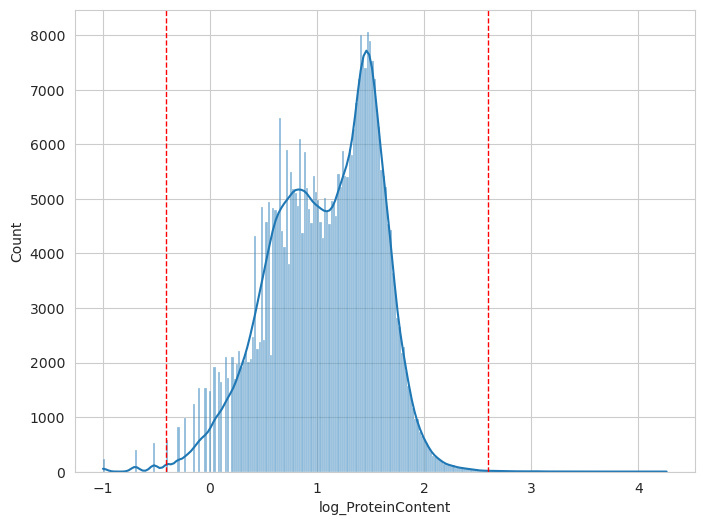

In [330]:
Q1 = recipes_continuous['log_ProteinContent'].quantile(0.25)
Q3 = recipes_continuous['log_ProteinContent'].quantile(0.75)

# Calculate IQR (Interquartile Range)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Protein Content lower bound:", round(10 ** lower_bound, 3))
print("Protein Content upper bound:", round(10 ** upper_bound, 3))

# Plot histogram and whisker boundaries as vertical lines
plt.figure(figsize=(8,6))
sns.histplot(data=recipes_continuous, x='log_ProteinContent', bins=250, kde=True)

plt.axvline(x=lower_bound, color='r', linestyle='--', linewidth=1)
plt.axvline(x=upper_bound, color='r', linestyle='--', linewidth=1)

plt.show()

# Filter the data for possible outliers
clean_ProteinContent_indices = (recipes_continuous['log_ProteinContent'] >= lower_bound) & (recipes_continuous['log_ProteinContent'] <= upper_bound)
outliers_ProteinContent_indices = (recipes_continuous['log_ProteinContent'] < lower_bound) | (recipes_continuous['log_ProteinContent'] > upper_bound)

# recipes_continuous[outliers_ProteinContent_indices]

#### Retrrieveing a mask using all the indices of the continous attributes that get rid of outliers.

In [347]:
clean_masks = [] 

for attr in continuous_attr:
    attr_mask = globals()[f"clean_{attr}_indices"]
    clean_masks.append(attr_mask)

concatenated_masks = pd.concat(clean_masks, axis=1)
clean_overall_indices = concatenated_masks.all(axis=1)

In [356]:
# Loading cleaned data into a pickle file

log_continuous_attr = ['log_'+attr for attr in continuous_attr]
recipes_continuous[clean_overall_indices][['RecipeId']+continuous_attr+log_continuous_attr].to_pickle('../data/clean_columns/continuous_attr_clean.pk')

In [365]:
recipes_continuous_clean = pd.merge(recipes_continuous[clean_overall_indices],
                                    recipes[['RecipeId', 'AggregatedRating', 'ReviewCount', 'RecipeServings']],
                                    on='RecipeId',
                                    how='inner')

# Calculating percentage of null values in each column
null_percentage = recipes_continuous_clean[['AggregatedRating', 'ReviewCount', 'RecipeServings']].isnull().mean().round(3).sort_values(ascending=False)
print(null_percentage, "\n")

AggregatedRating    0.482
ReviewCount         0.471
RecipeServings      0.339
dtype: float64 

